# Toy Model Implementation

In [1]:
import os

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import torch

import plotnine as p9

sclembas_path = 'LEMBAS'
import sys
sys.path.insert(1, os.path.join(sclembas_path))
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [2]:
n_cores = 12
utils.set_cores(n_cores)

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = 'LEMBAS/macrophage_data'

# Build the Model

## Load Input Data

In [3]:
# Prior knowledge signaling network
#net_og = pd.read_csv(os.path.join(data_path, 'macrophage-Model.tsv'), sep = '\t', index_col = False)
net = pd.read_csv('data/KEGGnet-Model.tsv', sep = '\t', index_col = False)

# Synthetic data input and output
#ligand_input = pd.read_csv(os.path.join(data_path, 'macrophage-Ligands.tsv'), sep='\t', low_memory=False, index_col=0)
#tf_output = pd.read_csv(os.path.join(data_path, 'macrophage-TFs.tsv'), sep='\t', low_memory=False, index_col=0)

synthetic_data = pd.read_csv(os.path.join('data', 'synthetic_data.csv'), sep=',', low_memory=False, index_col=0)
synthetic_data.set_index('Signaling Node', append=True, inplace=True)

conditions = synthetic_data.index.levels[0]
signaling_nodes = synthetic_data.index.levels[1]
ones_matrix = np.ones((len(conditions), len(signaling_nodes)), dtype=int)
condition_input = pd.DataFrame(ones_matrix, index=conditions, columns=signaling_nodes)

last_column_data = synthetic_data.iloc[:, -1].values
dim1 = synthetic_data.index.levels[0].size  # Number of unique conditions
dim2 = synthetic_data.index.levels[1].size  # Number of unique signaling nodes
reshaped_data = last_column_data.reshape((dim1, dim2))
nodeNames = synthetic_data.index.levels[1]
data_out = pd.DataFrame(reshaped_data, index=synthetic_data.index.levels[0], columns=nodeNames)

In [4]:
display(net.head())
#display(net_og.tail())
display(condition_input.head())
#display(ligand_input.head())
display(data_out.head())
#display(tf_output.head())

,source,target,direction,stimulation,inhibition,sources,references
0,O15111,P19838,1,1,0,CancerCellMap;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIM...,CancerCellMap:10469655;CancerCellMap:12482991;...
1,P45985,P45983,1,1,0,ACSN;ELM;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;Inn...,ACSN:11274345;ACSN:12624093;ACSN:12738796;ACSN...
2,Q13009,P63000,1,1,0,ACSN;Adhesome;BioGRID;CA1;HPRD;KEGG;Lit-BM-17;...,ACSN:11955434;ACSN:12829230;ACSN:15611338;ACSN...
3,P01112,Q13009,1,1,0,ACSN;Adhesome;HPRD;InnateDB;KEGG;SPIKE;Wang,ACSN:12134164;ACSN:7673236;ACSN:9069260;Adheso...
4,Q92851,P55957,1,1,0,HPRD;KEGG;SPIKE,HPRD:15772077;SPIKE:16186808


Signaling Node,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Condition,,,,,,,,,,,,,,,,,,,,,
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
11,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
15,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Signaling Node,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Condition,,,,,,,,,,,,,,,,,,,,,
4,-0.000015,0.020825,0.011471,-0.000306,0.000002,-0.002117,-0.000232,-0.000018,-0.005034,0.009005,...,0.042318,0.799319,0.914208,0.346605,0.050199,-0.001194,0.132100,-0.002849,-0.000151,0.059037
10,-0.000015,0.020825,0.011471,-0.000306,0.000001,0.846140,-0.000232,-0.000018,0.771188,0.009005,...,-0.000039,0.220740,0.758061,0.292925,0.050199,-0.003234,0.135500,-0.002867,-0.000151,0.059037
11,-0.000015,0.020825,0.011471,-0.000306,0.000001,0.846574,-0.000232,-0.000018,0.775378,0.009005,...,-0.000037,0.218746,0.757932,0.292850,0.050199,-0.003237,0.135574,-0.002868,-0.000151,0.059037
12,-0.000015,0.020825,0.011471,-0.000306,0.000001,0.846377,-0.000232,-0.000018,0.773231,0.009005,...,-0.000210,0.066595,0.746353,0.286937,0.050199,-0.003027,0.136848,-0.002879,-0.000151,0.059037
15,-0.000015,0.023396,0.011471,-0.000306,0.000001,0.844294,-0.000232,-0.000018,0.751679,0.009005,...,-0.000233,0.066676,0.747150,0.286928,0.050199,-0.002997,0.136577,-0.002876,-0.000151,0.059037


Let's see what the signaling network looks like:

In [5]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
0,O15111,P19838,1,0
1,P45985,P45983,1,0
2,Q13009,P63000,1,0
3,P01112,Q13009,1,0
4,Q92851,P55957,1,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [6]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()
net['mode_of_action'] = net['mode_of_action'].astype(int)  # Made MOA integers

# Define Parameters to Build and Train Model

In [7]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 5000, 
             'learning_rate': 2e-3}
other_params = {'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params} # fed into training function | ** are used to combine multiple dictionaries -> it unpacks them

## Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [8]:
mod = SignalingModel(net = net,
                     X_in = condition_input,
                     y_out = data_out, 
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     dtype = torch.float32, device = device, seed = seed)

X_in = mod.df_to_tensor(mod.X_in)
y_out = mod.df_to_tensor(mod.y_out)

source
target
['O00206', 'O14492', 'O14511', 'O14640', 'O14727', 'O14733', 'O14763', 'O14788', 'O14920', 'O14944', 'O15111', 'O15169', 'O15211', 'O15350', 'O15519', 'O15530', 'O43318', 'O43353', 'O43521', 'O43524', 'O43557', 'O43561', 'O43914', 'O60674', 'O60716', 'O60880', 'O75030', 'O75044', 'O75093', 'O75094', 'O75326', 'O75582', 'O75914', 'O94813', 'O95644', 'O95786', 'O96014', 'P00519', 'P00533', 'P00734', 'P01019', 'P01042', 'P01100', 'P01106', 'P01112', 'P01116', 'P01133', 'P01135', 'P01137', 'P01138', 'P01178', 'P01189', 'P01213', 'P01215', 'P01236', 'P01270', 'P01308', 'P01344', 'P01350', 'P01374', 'P01375', 'P01562', 'P01574', 'P01579', 'P01583', 'P01584', 'P01730', 'P01889', 'P02452', 'P02751', 'P03372', 'P04049', 'P04085', 'P04196', 'P04439', 'P04626', 'P04628', 'P04629', 'P04637', 'P05019', 'P05112', 'P05198', 'P05230', 'P05305', 'P05412', 'P05556', 'P06213', 'P06239', 'P06241', 'P06307', 'P06400', 'P07333', 'P07585', 'P08047', 'P08069', 'P08151', 'P08311', 'P08476', 'P085

The ligand input, after filtering for nodes in the network, looks like this:

In [9]:
mod.X_in.head()

Signaling Node,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Condition,,,,,,,,,,,,,,,,,,,,,
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
11,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
12,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
15,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


The TF activity output, after filtering for nodes in the network, looks like this:

In [10]:
mod.y_out.head()

Signaling Node,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Condition,,,,,,,,,,,,,,,,,,,,,
4,-0.000015,0.020825,0.011471,-0.000306,0.000002,-0.002117,-0.000232,-0.000018,-0.005034,0.009005,...,0.042318,0.799319,0.914208,0.346605,0.050199,-0.001194,0.132100,-0.002849,-0.000151,0.059037
10,-0.000015,0.020825,0.011471,-0.000306,0.000001,0.846140,-0.000232,-0.000018,0.771188,0.009005,...,-0.000039,0.220740,0.758061,0.292925,0.050199,-0.003234,0.135500,-0.002867,-0.000151,0.059037
11,-0.000015,0.020825,0.011471,-0.000306,0.000001,0.846574,-0.000232,-0.000018,0.775378,0.009005,...,-0.000037,0.218746,0.757932,0.292850,0.050199,-0.003237,0.135574,-0.002868,-0.000151,0.059037
12,-0.000015,0.020825,0.011471,-0.000306,0.000001,0.846377,-0.000232,-0.000018,0.773231,0.009005,...,-0.000210,0.066595,0.746353,0.286937,0.050199,-0.003027,0.136848,-0.002879,-0.000151,0.059037
15,-0.000015,0.023396,0.011471,-0.000306,0.000001,0.844294,-0.000232,-0.000018,0.751679,0.009005,...,-0.000233,0.066676,0.747150,0.286928,0.050199,-0.002997,0.136577,-0.002876,-0.000151,0.059037


A forward pass looks like this:

In [31]:
# X_in = mod.df_to_tensor(mod.X_in) # ligand inputs
# X_full = mod.input_layer(X_in) # ligand inputs in signaling network
# Y_full = mod.signaling_network(X_full) # signaling network weights
# Y_hat = mod.output_layer(Y_full) # TF outputs of signaling network

## Train Model

In [11]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_val, y_train, y_test, y_val = train_signaling_model(
    mod, optimizer, loss_fn, reset_epoch = 200, hyper_params = hyper_params, train_seed = seed, verbose = True) 

# store results
io.write_pickled_object(stats, os.path.join(data_path, 'training_stats.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join(data_path, 'mac_state_dict.pth'))

i=0, l=1.02053, s=0.011, r=0.00020, v=0
i=250, l=0.25809, s=0.022, r=0.00046, v=1
i=500, l=0.01961, s=0.030, r=0.00110, v=0
i=750, l=0.01962, s=0.042, r=0.00174, v=0
i=1000, l=0.01962, s=0.043, r=0.00200, v=0
i=1250, l=0.01962, s=0.018, r=0.00198, v=0
i=1500, l=0.01962, s=0.013, r=0.00191, v=0
i=1750, l=0.01962, s=0.016, r=0.00181, v=0
i=2000, l=0.01962, s=0.039, r=0.00167, v=0
i=2250, l=0.01962, s=0.013, r=0.00150, v=0
i=2500, l=0.01962, s=0.036, r=0.00131, v=0
i=2750, l=0.01961, s=0.017, r=0.00110, v=0
i=3000, l=0.01961, s=0.007, r=0.00090, v=0
i=3250, l=0.01961, s=0.015, r=0.00069, v=0
i=3500, l=0.01961, s=0.005, r=0.00050, v=0
i=3750, l=0.01960, s=0.003, r=0.00033, v=0
i=4000, l=0.01960, s=0.003, r=0.00019, v=0
i=4250, l=0.01960, s=0.001, r=0.00009, v=0
i=4500, l=0.01960, s=0.001, r=0.00002, v=0
i=4750, l=0.01960, s=0.001, r=0.00000, v=0
Training ran in: 10 min 29.17 sec


# Predict using the model:

In [12]:
mod.load_state_dict(torch.load(os.path.join(data_path, 'mac_state_dict.pth')))
stats = io.read_pickled_object(os.path.join(data_path, 'training_stats.pickle'))

C:\Users\kanto\AppData\Local\Temp\ipykernel_20968\2937762586.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [13]:
mod.eval()
Y_hat, Y_full = mod(X_in)

# Visualize

Let's see how the various stats performed across training:

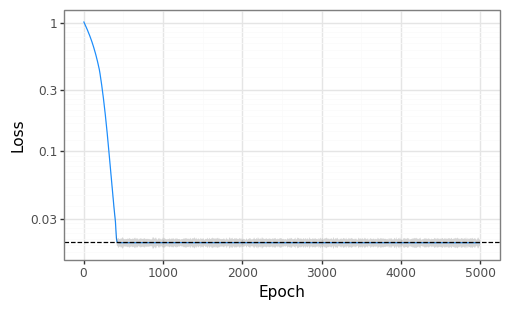

In [14]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
p1A += p9.geom_hline(yintercept = mean_loss.item(), linetype="dashed", color="black")
p1A.draw()

As well as how the learning rate was adjusted across training:

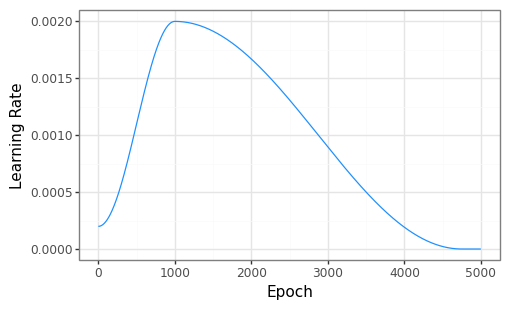

In [15]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

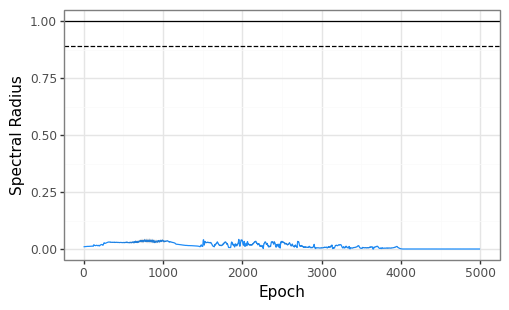

In [16]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

Next, let's see what the correlation between the predicted and actual transcription factor is:

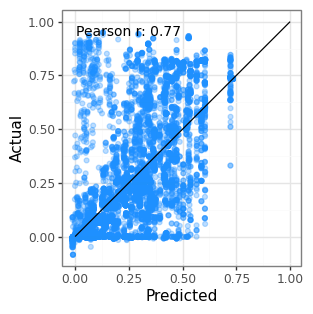

In [20]:
y_pred = Y_hat.detach().flatten().cpu().numpy()
y_actual = y_out.detach().flatten().cpu().numpy()

pr, _ = pearsonr(y_pred, y_actual)

viz_df = pd.DataFrame(data = {'Predicted': y_pred, 'Actual': y_actual})
width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.3) +
    p9.geom_line(data = pd.DataFrame(data = {'x': [0,1], 'y': [0, 1]}), mapping = p9.aes(x='x', y = 'y'), color = 'black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(geom = 'text', x=0.25, y = 0.95, label = 'Pearson r: {:.2f}'.format(pr), size = 10)
)
p2.draw()

Finally, let's see how our prediction error compares to error of the prediction relative to a control predicted on an input of no ligands. 

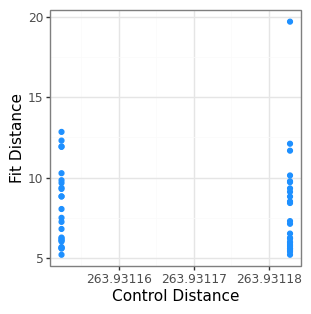

In [18]:
X_ctrl = torch.zeros((1, X_in.shape[1]), dtype=mod.dtype, device = mod.device)
Y_ctrl, _ = mod(X_ctrl)
signal_distance = torch.sum(torch.abs(Y_hat - Y_ctrl),dim=1).detach().cpu().numpy().flatten()
fit_distance = torch.sum(torch.square(Y_hat-y_out),dim=1).detach().cpu().numpy().flatten()


viz_df = pd.DataFrame(data = {'Control Distance': signal_distance, 'Fit Distance': fit_distance})
width, height = 3, 3
p3 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Control Distance', y = 'Fit Distance'), color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) 
)
p3.draw()